### Defend Your Home Against Hurricanes Using Data Science
#### This python tool retrieves the newest forecasted water level guidance and compares it to your home's base elevation to produce a graph which allows you to easily determine if barriers are necessary.
#### The barrier height can be determined by comparing the NOAA Extratropical Water Level Guidance to your home's base elevation.
##### NOAA ETSS Beautiful Soup Retriever
##### The first step utilizes the requests library to issue an HTTP get request.
##### This will retrieve the html data and store it in python for use.

In [24]:
import requests
from bs4 import BeautifulSoup

URL = "https://slosh.nws.noaa.gov/etsurge/index.php?page=stn&region=gm&datum=msl&list=&map=0-48&type=text&stn=flpete"
page = requests.get(URL)

print(page.text)
soup = BeautifulSoup(page.content, "html.parser") 

<!DOCTYPE html>
<html lang="en" xmlns="https://www.w3.org/1999/xhtml">
<head>
  <SCRIPT LANGUAGE="JavaScript"><!-- Hide script
// End hide -->
</SCRIPT>
  <title>ETSS stn</title>
  <meta name="DC.title" content="Extra-Tropical Storm Surge">
  <meta name="DC.description" content="Extra-Tropical Storm Surge landing page">
  <meta name="DC.creator" content="NWS/Meteorological Development Lab">
  <meta name="DC.language" scheme="DCTERMS.RFC1766" content="EN-US">
  <meta name="rating" content="general">
  <meta name="resource-type" content="document">
  <meta name="distribution" content="global">
  <meta http-equiv="Window-target" content="_top">
  <meta charset="iso-8859-1">
  <base target="_self">

  <link rel="stylesheet" type="text/css" href="ss/ssMain.css">
  <meta name="Keywords" content="etsurge, extra tropical storm surge, extra-tropical storm surge, extratropcial storm surge, storm surge, SLOSH">

  <link rel="stylesheet" type="text/css" href="etsurge2.0main.css"/>
  <link rel="sty

In [25]:
# Scrape the wrapper2 id to help reduce the amount of data.
#results = soup.find(id="wrapper2")
#print(results.prettify)

In [26]:
# Extract the content between the <pre> tags
pre_content = soup.find('pre').get_text()

# Output the NOAA etss data table 
print(pre_content)

#Saint Petersburg, FL : 10/27/2024 16:19:58 GMT (units in feet MSL)
#Date(GMT), Surge,   Tide,    Obs,   Fcst,   Anom, Comment
#------------------------------------------------------------
10/26 00Z,   0.50,  -0.23,   0.32,  99.90,   0.05,
10/26 01Z,   0.50,   0.08,   0.63,  99.90,   0.05,
10/26 02Z,   0.50,   0.34,   0.94,  99.90,   0.10,
10/26 03Z,   0.50,   0.54,   1.17,  99.90,   0.13,
10/26 04Z,   0.50,   0.63,   1.30,  99.90,   0.17,  (max)
10/26 05Z,   0.50,   0.62,   1.28,  99.90,   0.16,
10/26 06Z,   0.50,   0.54,   1.17,  99.90,   0.13,
10/26 07Z,   0.40,   0.44,   1.02,  99.90,   0.18,
10/26 08Z,   0.40,   0.36,   0.83,  99.90,   0.07,
10/26 09Z,   0.40,   0.35,   0.69,  99.90,  -0.06,
10/26 10Z,   0.40,   0.41,   0.64,  99.90,  -0.17,  (min)
10/26 11Z,   0.40,   0.53,   0.74,  99.90,  -0.19,
10/26 12Z,   0.40,   0.67,   0.90,  99.90,  -0.17,
10/26 13Z,   0.40,   0.80,   1.13,  99.90,  -0.07,
10/26 14Z,   0.40,   0.87,   1.32,  99.90,   0.05,
10/26 15Z,   0.40,   0.85,   1.3

### Now let's create a pandas dataframe from the data. This will allow us to calculate and plot parameters
#### All values of 99.90 have been replaced with NaN. NOAA's dataset should be examined to understand 99.90 values.


In [27]:
import pandas as pd
import numpy as np

# Split the NOAA pre_content from the ETSS website
lines = pre_content.splitlines()

# Filter out comments and empty lines (lines start with '#')
data_lines = [line for line in lines if not line.startswith('#') and line.strip()]

# Split each valid line by commas and remove extra spaces
data = [line.split(',') for line in data_lines]

# Create Pandas DataFrame from the extracted data
columns = ['Date(GMT)', 'Surge', 'Tide', 'Obs', 'Fcst', 'Anom', 'Comment']
df = pd.DataFrame(data, columns=columns)

# Apply strip to all string cells in the DataFrame
df = df.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

# Convert numeric columns to appropriate data types
df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']] = df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']].astype(float)

# Replace any value equal to 99.90 with NaN
df.replace(99.90, np.nan, inplace=True)

# Print df
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment
0    10/26 00Z    0.5 -0.23  0.32   NaN  0.05        
1    10/26 01Z    0.5  0.08  0.63   NaN  0.05        
2    10/26 02Z    0.5  0.34  0.94   NaN  0.10        
3    10/26 03Z    0.5  0.54  1.17   NaN  0.13        
4    10/26 04Z    0.5  0.63  1.30   NaN  0.17   (max)
..         ...    ...   ...   ...   ...   ...     ...
128  10/31 08Z    NaN  0.45   NaN   NaN  0.11        
129  10/31 09Z    NaN -0.02   NaN   NaN  0.11        
130  10/31 10Z    NaN -0.49   NaN   NaN  0.11        
131  10/31 11Z    NaN -0.86   NaN   NaN  0.11        
132  10/31 12Z    NaN -1.04   NaN   NaN  0.11        

[133 rows x 7 columns]


### Set the Home Base Elevation to Compare with Total Water Level Guidance

In [28]:
# Set the home base elevation value (MSL ft)
#home_base_elev = 6.2
home_base_elev = 3.67

### Plot the Date(GMT) versus the Observed, Forecasted (MSL feet), and Home Base Elevations

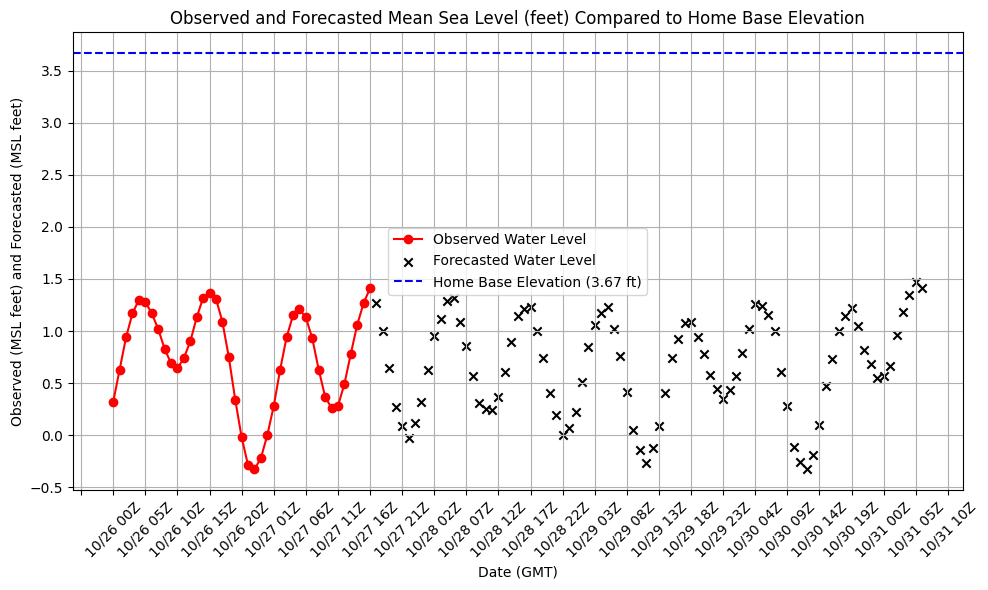

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot data on figure (x) vs (y)
plt.figure(figsize=(10, 6))

# X values will be 'Date(GMT)' and Y values will be 'Obs'
plt.plot(df['Date(GMT)'], df['Obs'], marker='o', linestyle='-', color='r', label='Observed Water Level')
# Add Fcst values as black 'X' markers
plt.scatter(df['Date(GMT)'], df['Fcst'], color='black', marker='x', label='Forecasted Water Level')
# Add a horizontal line at y = home_base_elev
plt.axhline(y=home_base_elev, color='b', linestyle='--', label=f'Home Base Elevation ({home_base_elev} ft)')

# Formatting the plot
plt.xlabel('Date (GMT)')
plt.ylabel('Observed (MSL feet) and Forecasted (MSL feet)')
plt.title('Observed and Forecasted Mean Sea Level (feet) Compared to Home Base Elevation')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
# Reducing the number of dates/times on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit to 6 x-axis labels

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [30]:
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment
0    10/26 00Z    0.5 -0.23  0.32   NaN  0.05        
1    10/26 01Z    0.5  0.08  0.63   NaN  0.05        
2    10/26 02Z    0.5  0.34  0.94   NaN  0.10        
3    10/26 03Z    0.5  0.54  1.17   NaN  0.13        
4    10/26 04Z    0.5  0.63  1.30   NaN  0.17   (max)
..         ...    ...   ...   ...   ...   ...     ...
128  10/31 08Z    NaN  0.45   NaN   NaN  0.11        
129  10/31 09Z    NaN -0.02   NaN   NaN  0.11        
130  10/31 10Z    NaN -0.49   NaN   NaN  0.11        
131  10/31 11Z    NaN -0.86   NaN   NaN  0.11        
132  10/31 12Z    NaN -1.04   NaN   NaN  0.11        

[133 rows x 7 columns]


In [31]:
# Add Columns Barrier_HeightObs and Barrier_HeightFcst to df
df['Barrier_HeightObs'] = df['Obs'] - home_base_elev
df['Barrier_HeightFcst'] = df['Fcst'] - home_base_elev

In [32]:
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment  Barrier_HeightObs  \
0    10/26 00Z    0.5 -0.23  0.32   NaN  0.05                      -3.35   
1    10/26 01Z    0.5  0.08  0.63   NaN  0.05                      -3.04   
2    10/26 02Z    0.5  0.34  0.94   NaN  0.10                      -2.73   
3    10/26 03Z    0.5  0.54  1.17   NaN  0.13                      -2.50   
4    10/26 04Z    0.5  0.63  1.30   NaN  0.17   (max)              -2.37   
..         ...    ...   ...   ...   ...   ...     ...                ...   
128  10/31 08Z    NaN  0.45   NaN   NaN  0.11                        NaN   
129  10/31 09Z    NaN -0.02   NaN   NaN  0.11                        NaN   
130  10/31 10Z    NaN -0.49   NaN   NaN  0.11                        NaN   
131  10/31 11Z    NaN -0.86   NaN   NaN  0.11                        NaN   
132  10/31 12Z    NaN -1.04   NaN   NaN  0.11                        NaN   

     Barrier_HeightFcst  
0                   NaN  
1                   NaN  
2        

In [33]:
# Create Barrier_Height column that checks if Barrier_HeightObs or Barrier_HeightFcst are greater than zero, if true print the positive number, if not NaN
df['Barrier_HeightReq'] = np.where(df['Barrier_HeightObs'] > 0, df['Barrier_HeightObs'],
                        np.where(df['Barrier_HeightFcst'] > 0, df['Barrier_HeightFcst'], np.nan))
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment  Barrier_HeightObs  \
0    10/26 00Z    0.5 -0.23  0.32   NaN  0.05                      -3.35   
1    10/26 01Z    0.5  0.08  0.63   NaN  0.05                      -3.04   
2    10/26 02Z    0.5  0.34  0.94   NaN  0.10                      -2.73   
3    10/26 03Z    0.5  0.54  1.17   NaN  0.13                      -2.50   
4    10/26 04Z    0.5  0.63  1.30   NaN  0.17   (max)              -2.37   
..         ...    ...   ...   ...   ...   ...     ...                ...   
128  10/31 08Z    NaN  0.45   NaN   NaN  0.11                        NaN   
129  10/31 09Z    NaN -0.02   NaN   NaN  0.11                        NaN   
130  10/31 10Z    NaN -0.49   NaN   NaN  0.11                        NaN   
131  10/31 11Z    NaN -0.86   NaN   NaN  0.11                        NaN   
132  10/31 12Z    NaN -1.04   NaN   NaN  0.11                        NaN   

     Barrier_HeightFcst  Barrier_HeightReq  
0                   NaN                NaN

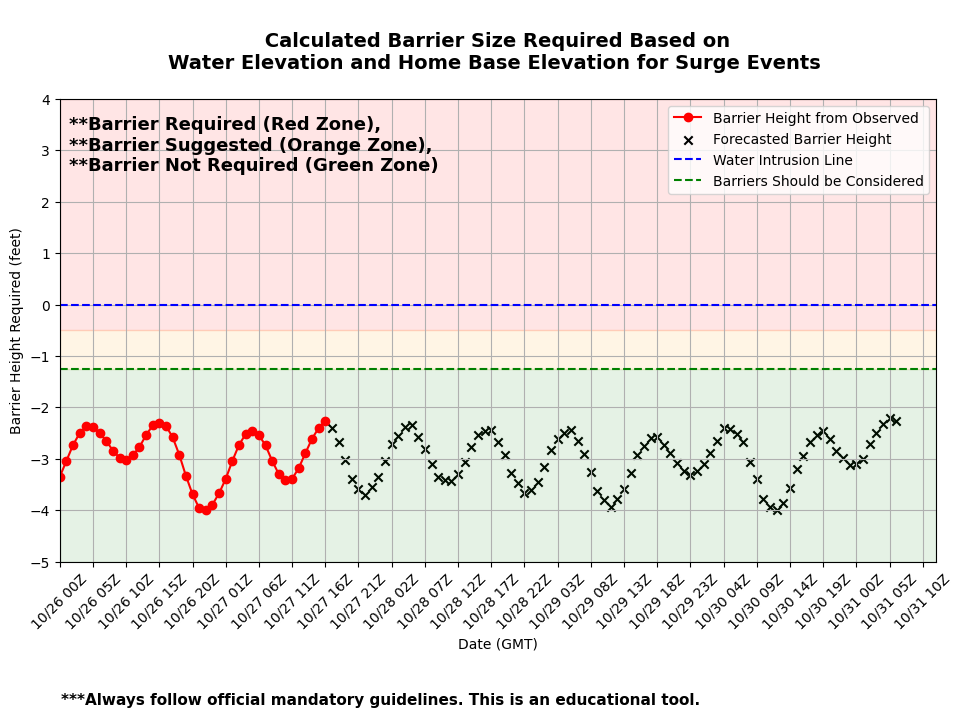

In [34]:
# Plot data on figure (x) vs (y)
plt.figure(figsize=(10, 8))

# X values will be 'Date(GMT)' and Y values will be 'Obs'
plt.plot(df['Date(GMT)'], df['Barrier_HeightObs'], marker='o', linestyle='-', color='r', label='Barrier Height from Observed')
# Add Fcst values as black 'X' markers
plt.scatter(df['Date(GMT)'], df['Barrier_HeightFcst'], color='black', marker='x', label='Forecasted Barrier Height')
# Add Barrier_HeightReq values as yellow 'o' markers
#plt.scatter(df['Date(GMT)'], df['Barrier_HeightReq'], color='black', marker='o', label='Barrier Height Required')

# Add a horizontal line at y = 0
plt.axhline(y=0, color='b', linestyle='--', label=f'Water Intrusion Line')
# Add a horizontal line at y = 0
plt.axhline(y=-1.25, color='g', linestyle='--', label=f'Barriers Should be Considered')

# Add fill between y = -5 and y = -1
plt.fill_between(df['Date(GMT)'], -5, -1.25, color='green', alpha=0.1)
# Add fill between y = -1 and y = 0
plt.fill_between(df['Date(GMT)'], -1.25, -0.5, color='orange', alpha=0.1)
# Add fill between y = 3 and y = 0
plt.fill_between(df['Date(GMT)'], 4, -0.5, color='red', alpha=0.1)

# Formatting the plot
plt.xlabel('Date (GMT)')
plt.ylabel('Barrier Height Required (feet)')
plt.title('\n Calculated Barrier Size Required Based on \nWater Elevation and Home Base Elevation for Surge Events \n', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Set x-axis limits to start and end at first and last data points
plt.xlim(df['Date(GMT)'].iloc[0], df['Date(GMT)'].iloc[-1])  # Start and end at first and last points
plt.ylim(-5,4)
# Reducing the number of dates/times on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit to 6 x-axis labels

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding the note above the legend
plt.text(0.01, 0.90, "**Barrier Required (Red Zone),\n**Barrier Suggested (Orange Zone),\n**Barrier Not Required (Green Zone)",
         ha='left', va='center', transform=plt.gca().transAxes, fontsize=13, color='black', fontweight='bold')

# Adding the note bottom left
plt.text(0.001, -0.3, "***Always follow official mandatory guidelines. This is an educational tool.",
         ha='left', va='center', transform=plt.gca().transAxes, fontsize=11, color='black', fontweight='bold')

# tight_layout to automatically adjust plotting parameters
plt.tight_layout(pad=2.0)

# Save the plot as a JPEG file
#plt.savefig("C:/KG_MobileFiles_2024/Python/sample_plot.jpg", format='jpg')

# Display the plot
plt.show()
